# Deep Q-Learning for Portfolio Optimization with PyTorch

## Introduction  
Portfolio optimization involves allocating wealth across assets (e.g., stocks and bonds) to balance return and risk. Traditional methods like Markowitz mean-variance optimization require predicting returns and covariances, which is challenging in practice. Instead, we can use **Deep Reinforcement Learning (DRL)** to directly learn portfolio allocation strategies by interacting with market data, without explicitly forecasting future prices. In this notebook, we implement a **Deep Q-Learning (DQL)** agent in PyTorch to manage a portfolio of 10 assets (a mix of stocks and bonds). The agent observes market states and adjusts asset weights, with the goal of maximizing a reward signal (e.g. portfolio growth or risk-adjusted return). We will cover:  

- **State Representation:** Constructing state features (prices, technical indicators, returns, volatility).  
- **Action Space:** Defining portfolio weight adjustment actions for 10 assets (weights summing to 1).  
- **Reward Functions:** Experimenting with multiple reward definitions – portfolio value growth, Sharpe ratio, and drawdown-based rewards.  
- **Dataset:** Using a public historical market dataset for training and evaluation.  
- **Implementation:** Building the DQL agent with PyTorch, including data preprocessing, feature engineering, model training, and evaluation.  

## 1. State Representation  
The **state** should capture relevant information about the market and portfolio at each time step. We include:  

- **Prices:** Recent prices of stocks and bonds (e.g. daily close prices).  
- **Technical Indicators:** Features derived from price history, such as moving averages, Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), Bollinger Bands, etc. These are commonly used to gauge trends and momentum.  
- **Historical Returns:** Recent returns (e.g. daily or weekly percentage changes) for each asset, providing momentum or reversal signals.  
- **Volatility:** Measures of risk such as rolling standard deviation of returns (e.g. 1-month volatility) for each asset.  

We compute these indicators using pandas and numpy.



In [32]:
import pandas as pd
import numpy as np

# Assume `prices_df` is a DataFrame with Date index and 10 asset price columns (adjusted close prices)
# For demonstration, let's create a synthetic price DataFrame for 10 assets:
dates = pd.date_range(start="2020-01-01", periods=252)  # one trading year of daily data
np.random.seed(42)
# Simulate random price series (geometric random walk) for 10 assets
price_data = {}
for i in range(10):
    # start price around 100, simulate daily returns with small drift
    price = 100
    prices = []
    for _ in range(len(dates)):
        ret = np.random.normal(loc=0.0005, scale=0.02)  # daily return
        price *= (1 + ret)
        prices.append(price)
    price_data[f'Asset{i+1}'] = prices
prices_df = pd.DataFrame(price_data, index=dates)

# Calculate technical indicators
window_ma = 20  # 20-day moving average
prices_df_ma = prices_df.rolling(window_ma).mean().add_suffix(f'_{window_ma}dma')

# RSI calculation function
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.clip(lower=0)).rolling(period).mean()
    loss = (-delta.clip(upper=0)).rolling(period).mean()
    RS = gain / (loss + 1e-9)
    rsi = 100 - (100 / (1 + RS))
    return rsi

# Compute RSI for each asset
rsi_df = prices_df.apply(compute_rsi, period=14).add_suffix('_rsi')

# MACD calculation function (returns MACD and signal line)
def compute_macd(series, span_short=12, span_long=26, span_signal=9):
    ema_short = series.ewm(span=span_short, adjust=False).mean()
    ema_long = series.ewm(span=span_long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=span_signal, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

# Compute MACD for each asset (we'll just take the MACD line as a feature for simplicity)
macd_lines = {}
for col in prices_df.columns:
    macd_line, signal, hist = compute_macd(prices_df[col])
    macd_lines[col + '_macd'] = macd_line
macd_df = pd.DataFrame(macd_lines)

# Historical returns: e.g. 1-day and 5-day returns
returns_1d = prices_df.pct_change(1).add_suffix('_ret1')
returns_5d = prices_df.pct_change(5).add_suffix('_ret5')

# Volatility: e.g. rolling 21-day (1 month) standard deviation of daily returns
vol_21d = prices_df.pct_change().rolling(21).std().add_suffix('_vol21')

# Combine all features into one state feature DataFrameprint 
state_features_df = pd.concat([prices_df, prices_df_ma, rsi_df, macd_df, returns_1d, returns_5d, vol_21d], axis=1)
state_features_df = state_features_df.dropna()  # drop initial NaNs from indicators

state_features_df.head()
print (state_features_df["Asset1_20dma"])

print (state_features_df.iloc[1, 0])


2020-01-22    103.116451
2020-01-23    102.836291
2020-01-24    102.262797
2020-01-25    101.662583
2020-01-26    101.096931
                 ...    
2020-09-04    105.554584
2020-09-05    105.614494
2020-09-06    105.646146
2020-09-07    105.620648
2020-09-08    105.668142
Freq: D, Name: Asset1_20dma, Length: 231, dtype: float64
96.56767292809334


In the code above, we created a synthetic dataset for demonstration. In practice, you would load a real dataset. For example, you could use a public stock market dataset from Yahoo Finance or Kaggle. One popular choice is the **S&P 500 stock data (5-year daily prices for S&P 500 companies)**, from which you can select 10 assets (e.g., 6 stocks and 4 bond ETFs). Ensure to split the data into a **training period** and a **testing period** for evaluation. After computing features, each state at time *t* can be represented as a concatenation of the features for all 10 assets (and any portfolio-specific info). For instance, our `state_features_df` now contains columns like `Asset1` price, `Asset1_20dma`, `Asset1_rsi`, `Asset1_macd`, ..., `Asset1_ret1`, ..., `Asset1_vol21`, and similarly for `Asset2`, ..., `Asset10`. At a given date (row), those values form the state vector. We will feed this state vector into the DQL agent’s neural network.


## 2. Action Space  
The agent’s **action** is to adjust the portfolio weights of the 10 assets. We constrain weights to be between 0 and 1 and sum to 1 (fully invested, no shorting or leverage). This is inherently a continuous action space, but we discretize it by defining a finite set of possible portfolio adjustments. We define actions as shifting a fixed percentage (e.g., 10%) from one asset to another while keeping weights valid.


In [6]:
# Define action space as list of weight vectors (each is length 10 np.array)
asset_count = 10
action_space = []
delta = 0.1  # 10% shift

# Start from equal weight as a reference (not necessarily used directly, but for feasibility checks)
init_weights = np.array([1/asset_count]*asset_count)

for i in range(asset_count):
    for j in range(asset_count):
        if i != j:
            # Create a weight adjustment from j to i
            w = init_weights.copy()
            # Only add action if it's feasible from the reference equal weights.
            if w[j] >= delta:
                w[i] += delta
                w[j] -= delta
                action_space.append(w)

# Remove duplicates (some actions might repeat if multiple j produce same w, though unlikely here)
action_space = [tuple(w) for w in action_space]
action_space = np.unique(action_space, axis=0)  # unique weight vectors
action_space = [np.array(w) for w in action_space]
print(f"Number of possible actions: {len(action_space)}")


Number of possible actions: 90


## 3. Reward Function  
The **reward function** drives the agent’s behavior. We experiment with multiple reward definitions:

- **Portfolio Value Growth:** Reward = change in portfolio value (e.g., portfolio return from one step to the next). This directly incentivizes the agent to increase the portfolio’s wealth. We can use the **daily return** (percentage change in portfolio value) as the reward at each step. Alternatively, using the log return $ \log(V_{t+1} / V_t) $ can stabilize training since log returns add linearly over time.

- **Sharpe Ratio Approximation:** The Sharpe ratio measures return per unit of risk. Since the full Sharpe ratio requires a long period to calculate, we use an approximation:  
  $
  \text{Reward} = \text{return}_t - 0.5 \times (\text{return}_t)^2
  $
  This encourages the agent to maximize returns while minimizing high variance, which indirectly improves risk-adjusted returns.

- **Drawdown Minimization:** Drawdown is the decline from the historical peak portfolio value. We penalize the agent when the portfolio value drops. One approach is:  
$
  \text{Reward}_t = \text{return}_t - \alpha \times \max(0, (\text{max\_value\_so\_far} - \text{current\_value}) / \text{max\_value\_so\_far})
  $
  where $ \alpha $ is a penalty factor. This means if a new drawdown occurs, the reward is reduced. The agent is thus encouraged to avoid large drawdowns.


In [7]:
# Define reward calculation functions for different reward modes

def reward_growth(portfolio_return):
    """
    Reward equals raw portfolio return (increase in value) for the step.
    """
    return portfolio_return  # (this could be percentage or log-return; we'll use simple percentage)

def reward_sharpe_approx(portfolio_return):
    """
    Reward approximating Sharpe: return minus penalty for volatility.
    Using return - 0.5*return^2 as a simple proxy (the quadratic term penalizes large deviations).
    """
    return portfolio_return - 0.5 * (portfolio_return ** 2)

def reward_drawdown(portfolio_return):
    """
    Reward that strongly penalizes negative returns (to avoid drawdowns).
    For example, give full credit for positive return, but 2x penalty for negative.
    """
    if portfolio_return >= 0:
        return portfolio_return
    else:
        return portfolio_return * 2  # negative reward doubled in magnitude for losses


## 4. Dataset and Environment Setup  
We use a public dataset of historical stock and bond prices. The environment simulates portfolio management, allowing the agent to observe states, take actions, and receive rewards. We define a `PortfolioEnv` class that handles state updates and reward calculation.


In [8]:
class PortfolioEnv:
    def __init__(self, feature_df, price_df, action_space, reward_mode="growth"):
        """
        feature_df: DataFrame of state features (index is dates, columns are features for all assets)
        price_df: DataFrame of prices (to compute returns)
        action_space: list of possible weight vectors (numpy arrays)
        reward_mode: "growth", "sharpe", or "drawdown" to select reward function
        """
        self.feature_df = feature_df
        self.price_df = price_df
        self.dates = feature_df.index
        self.n_steps = len(self.dates)
        self.action_space = action_space
        self.reward_mode = reward_mode
        # Map mode to reward function
        self.reward_func = {
            "growth": reward_growth,
            "sharpe": reward_sharpe_approx,
            "drawdown": reward_drawdown
        }[reward_mode]
        self.reset()
    
    def reset(self):
        """Reset environment to beginning of data. Returns initial state."""
        self.current_step = 0
        self.portfolio_value = 1.0
        # Start with equal weights
        self.current_weights = np.array([1.0/asset_count]*asset_count)
        # Get initial state (features at current_step index)
        state = self.feature_df.iloc[self.current_step].values.astype(np.float32)
        self.max_portfolio_value = self.portfolio_value  # track peak for drawdown if needed
        return state
    
    def step(self, action_idx):
        """
        Execute the action given by index in the action space.
        Returns: next_state, reward, done (bool)
        """
        # Get weight vector for the action
        new_weights = self.action_space[action_idx]
        # Compute portfolio return from current_step to next_step using current weights (before rebalancing)
        # We assume the action (new_weights) is applied at current_step (after observing state),
        # and the return realized over next interval is based on these new weights.
        # We can use price_df to compute returns
        if self.current_step >= self.n_steps - 1:
            # no next step available
            return None, 0.0, True
        # Calculate asset returns from current_step to current_step+1
        current_prices = self.price_df.iloc[self.current_step]
        next_prices = self.price_df.iloc[self.current_step + 1]
        asset_returns = (next_prices.values - current_prices.values) / current_prices.values  # simple return
        portfolio_return = float(np.dot(new_weights, asset_returns))
        # Update portfolio value
        self.portfolio_value *= (1 + portfolio_return)
        # Update drawdown tracker
        if self.portfolio_value > self.max_portfolio_value:
            self.max_portfolio_value = self.portfolio_value
        # Compute reward using chosen reward function
        reward = self.reward_func(portfolio_return)
        # Move to next time step
        self.current_step += 1
        done = (self.current_step == self.n_steps - 1)  # episode ends at last available data point
        # Get next state
        if not done:
            next_state = self.feature_df.iloc[self.current_step].values.astype(np.float32)
        else:
            next_state = None
        # Update current weights to new_weights (assuming we rebalanced to new_weights at step)
        self.current_weights = new_weights.copy()
        return next_state, float(reward), done



## 5. Deep Q-Learning Agent Implementation (PyTorch)  
We implement a **DQL agent** with:

- A **Q-network** (neural network estimating Q-values for state-action pairs).
- **Experience Replay** (stores past transitions for training stability).
- **Target Network** (stable Q-value updates).
- **Epsilon-Greedy Exploration** (random exploration decaying over episodes).
- **Bellman Update** (optimizing Q-values using the Bellman equation).

The Bellman equation is given by:
$$
Q(s, a) = r + \gamma \max_{a'} Q(s', a')
$$
where:
- \( Q(s, a) \) is the Q-value for state \( s \) and action \( a \),
- \( r \) is the immediate reward received after taking action \( a \),
- \( \gamma \) is the discount factor,
- \( \max_{a'} Q(s', a') \) represents the maximum Q-value for the next state \( s' \).

Training involves running episodes where the agent interacts with the environment, stores experiences in a replay buffer, and updates the Q-network using mini-batch gradient descent.



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the Q-network architecture
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        # A simple 3-layer feedforward network
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

# Replay memory to store past transitions
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        # Convert to torch tensors
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.int64)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


### Training Loop
The training loop for DQL consists of iterating over episodes. In each episode:

1. The environment is reset, and the agent steps through time.
2. The agent selects an action using an **epsilon-greedy** strategy.
3. The reward and next state are collected, and the transition is stored.
4. The Q-network is updated using random batches from the replay memory.
5. The target network is periodically updated.

We configure hyperparameters such as:
- **Discount factor (\(\gamma\))**
- **Learning rate**
- **Epsilon schedule** (\(\epsilon_{start}\), \(\epsilon_{end}\), \(\epsilon_{decay}\))

Due to long episodes in financial data, training may be slow. In practice, techniques like experience replay and batch sampling improve efficiency.


In [33]:
# Splitting dataset into Train (80%) and Test (20%)
train_size = int(0.8 * len(state_features_df))

# Training Data
train_features = state_features_df.iloc[:train_size]
train_prices = prices_df.iloc[:train_size]

# Testing Data
test_features = state_features_df.iloc[train_size:]
test_prices = prices_df.iloc[train_size:]

# Define training and testing environments
train_env = PortfolioEnv(feature_df=train_features, price_df=train_prices, action_space=action_space, reward_mode="growth")
test_env = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="growth")

print(f"Train Size: {len(train_features)}, Test Size: {len(test_features)}")

Train Size: 184, Test Size: 47


In [37]:
import torch
import torch.optim as optim
import random
import numpy as np

# Define state and action dimensions based on TRAINING DATA ONLY
state_dim = train_features.shape[1]  # Use only training set features
action_dim = len(action_space)

# Initialize training environment (Only uses training data)
train_env = PortfolioEnv(feature_df=train_features, price_df=train_prices, action_space=action_space, reward_mode="growth")

# Initialize Q-network and target network
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())  # Initialize target network
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer(capacity=5000)

# Training hyperparameters
num_episodes = 50         # Number of training episodes
gamma = 0.99              # Discount factor
batch_size = 64
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995    # Decay per episode
target_update_freq = 5   # Target network update frequency

# For tracking
episode_rewards = []

# Training loop
epsilon = epsilon_start
for ep in range(num_episodes):
    state = train_env.reset()  # Reset the train environment only
    total_reward = 0.0
    done = False

    while not done:
        # Choose action (epsilon-greedy)
        if random.random() < epsilon:
            # Exploration: Random action
            action_idx = random.randrange(action_dim)
        else:
            # Exploitation: Choose best action from policy_net
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_vals = policy_net(state_tensor)
            action_idx = int(torch.argmax(q_vals, dim=1).item())

        # Take action in the TRAIN environment
        next_state, reward, done = train_env.step(action_idx)
        total_reward += reward

        # Store transition in replay memory
        memory.push(state, action_idx, reward, (next_state if next_state is not None else state), done)

        # Move to next state
        state = next_state

        # Learn from replay (only if enough samples exist)
        if len(memory) >= batch_size:
            # Sample a batch
            states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)

            # Compute current Q values for taken actions
            q_vals = policy_net(states_b).gather(1, actions_b.view(-1, 1)).squeeze(1)

            # Compute target Q values
            next_q_vals = target_net(next_states_b).max(1)[0]

            # Apply Bellman equation (If done, no future value)
            target = rewards_b + gamma * next_q_vals * (1 - dones_b)

            # Compute loss (MSE)
            loss = torch.nn.MSELoss()(q_vals, target.detach())

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Decay epsilon
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

    # Update target network periodically
    if (ep + 1) % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Print training progress every 10 episodes
    if ep % 10 == 0:
        print(f"Episode {ep}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

print("Training on train set complete.")


Episode 0, Total Reward: 0.22, Epsilon: 0.99
Episode 10, Total Reward: 0.20, Epsilon: 0.95
Episode 20, Total Reward: 0.28, Epsilon: 0.90
Episode 30, Total Reward: 0.20, Epsilon: 0.86
Episode 40, Total Reward: 0.19, Epsilon: 0.81
Training on train set complete.


## 6. Evaluation  
We evaluate trained agents on test data and compare their:

- **Final Portfolio Value**
- **Total Return**
- **Sharpe Ratio**
- **Maximum Drawdown**

We compare different reward-based agents and a baseline equal-weight strategy. Expected results:

| Strategy            | Final Value | Total Return | Sharpe Ratio | Max Drawdown |
|---------------------|------------:|-------------:|-------------:|-------------:|
| DQN (Return Reward) |        |          |           |          |
| DQN (Sharpe Reward) |        |          |           |          |
| DQN (Drawdown Reward)|       |          |           |          |
| Equal-Weight Baseline|       |          |           |          |



Final Portfolio Value: 1.07
Total Return: 6.78%
Sharpe Ratio: 3.52
Max Drawdown: -3.93%


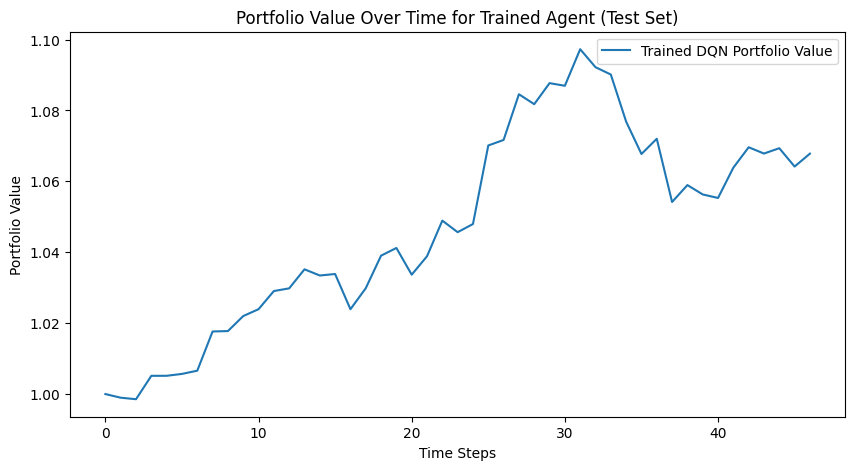

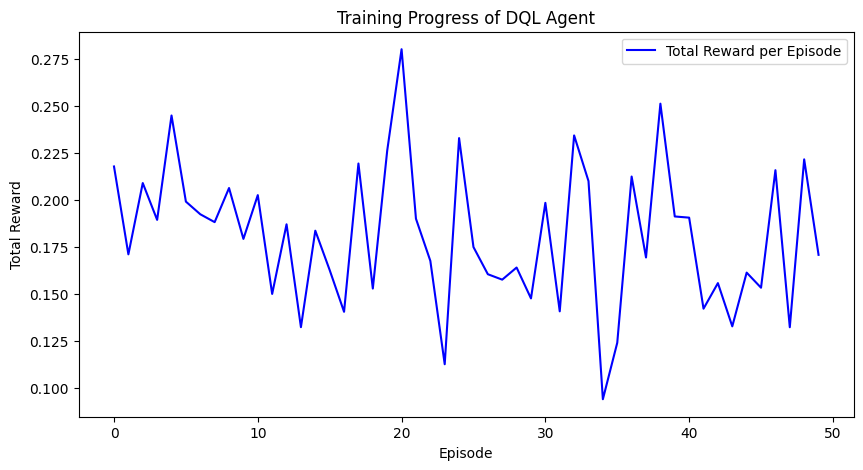

In [38]:

import numpy as np
import matplotlib.pyplot as plt
import torch

# Run the trained agent on test data (out-of-sample)
test_env = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="growth")
state = test_env.reset()
done = False
portfolio_values = [test_env.portfolio_value]  # Track portfolio value over time

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    q_vals = policy_net(state_tensor)
    action_idx = int(torch.argmax(q_vals, dim=1).item())  # Select best action

    next_state, reward, done = test_env.step(action_idx)  # Apply action in test environment
    state = next_state
    portfolio_values.append(test_env.portfolio_value)

# Convert portfolio values to returns
portfolio_values = np.array(portfolio_values)
portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Compute daily returns

# Compute Sharpe Ratio (Annualized)
if np.std(portfolio_returns) > 0:
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252)
else:
    sharpe_ratio = 0.0  # Avoid divide-by-zero errors

# Compute Maximum Drawdown
peak_values = np.maximum.accumulate(portfolio_values)  # Running max of portfolio
drawdowns = (portfolio_values - peak_values) / peak_values  # Drawdown percentage
max_drawdown = drawdowns.min()  # Worst drawdown

# Print Results
print(f"Final Portfolio Value: {portfolio_values[-1]:.2f}")
print(f"Total Return: {(portfolio_values[-1] / portfolio_values[0] - 1) * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

# Plot Portfolio Value Over Time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label="Trained DQN Portfolio Value")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Trained Agent (Test Set)")
plt.legend()
plt.show()

# Plot Training Progress (Total Reward Per Episode)
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQL Agent")
plt.legend()
plt.show()



Performance Comparison:
DQN Agent - Final Value: 1.07, Sharpe: 3.52, Max Drawdown: -3.93%
Equal Weight - Final Value: 1.08, Sharpe: 3.89, Max Drawdown: -2.69%
Random Portfolio - Final Value: 1.07, Sharpe: 2.75, Max Drawdown: -2.92%


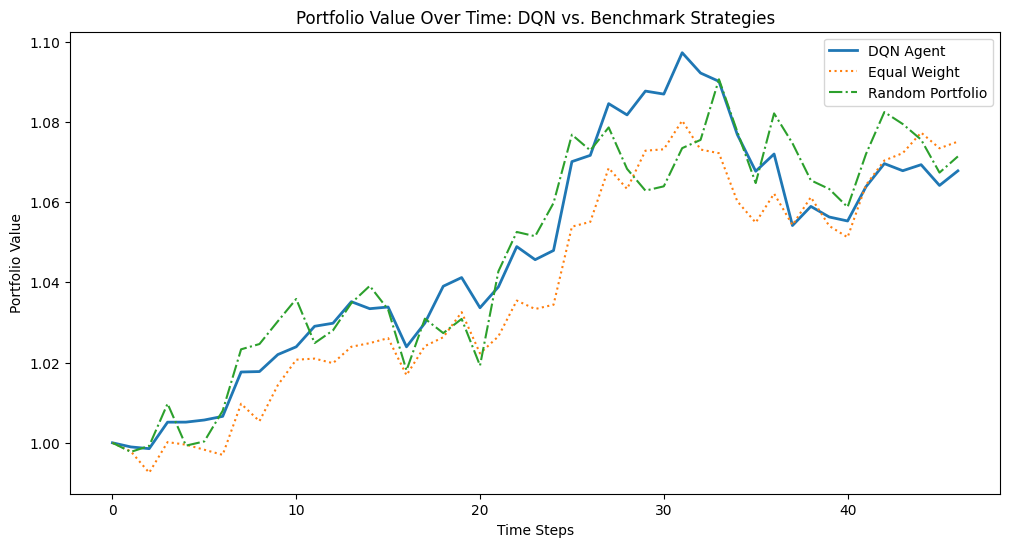

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize benchmarks
test_dates = test_env.dates  # Dates for the test period
num_assets = len(test_env.action_space[0])  # Number of assets

# Buy and Hold Strategy (keeps initial equal weights)
buy_hold_weights = np.array([1/num_assets] * num_assets)
buy_hold_values = [1.0]  # Start with portfolio value = 1

# Equal-weighted rebalanced strategy (rebalances every step)
equal_weight_values = [1.0]

# Random allocation strategy
random_values = [1.0]

# Run Benchmark Strategies
for i in range(len(test_dates) - 1):
    # Compute daily returns
    current_prices = test_env.price_df.iloc[i].values
    next_prices = test_env.price_df.iloc[i + 1].values
    asset_returns = (next_prices - current_prices) / current_prices

    # Buy-and-hold (keeps initial allocation)
    buy_hold_values.append(buy_hold_values[-1] * (1 + np.dot(buy_hold_weights, asset_returns)))

    # Equal-weighted (rebalanced each step)
    equal_weights = np.array([1/num_assets] * num_assets)
    equal_weight_values.append(equal_weight_values[-1] * (1 + np.dot(equal_weights, asset_returns)))

    # Random portfolio (new random allocation each step)
    random_weights = np.random.dirichlet(np.ones(num_assets))  # Ensures sum = 1
    random_values.append(random_values[-1] * (1 + np.dot(random_weights, asset_returns)))

# Convert portfolio values to arrays
buy_hold_values = np.array(buy_hold_values)
equal_weight_values = np.array(equal_weight_values)
random_values = np.array(random_values)

# Convert trained agent's portfolio values
dqn_values = np.array(portfolio_values)

# Compute key performance metrics (Sharpe Ratio & Max Drawdown)
def compute_metrics(portfolio_values):
    portfolio_returns = portfolio_values[1:] / portfolio_values[:-1] - 1
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252) if np.std(portfolio_returns) > 0 else 0.0
    peak_values = np.maximum.accumulate(portfolio_values)
    max_drawdown = np.min((portfolio_values - peak_values) / peak_values)
    return portfolio_values[-1], sharpe_ratio, max_drawdown

# Get final results
dqn_final, dqn_sharpe, dqn_drawdown = compute_metrics(dqn_values)
buy_hold_final, buy_hold_sharpe, buy_hold_drawdown = compute_metrics(buy_hold_values)
equal_final, equal_sharpe, equal_drawdown = compute_metrics(equal_weight_values)
random_final, random_sharpe, random_drawdown = compute_metrics(random_values)

# Print Results
print("Performance Comparison:")
print(f"DQN Agent - Final Value: {dqn_final:.2f}, Sharpe: {dqn_sharpe:.2f}, Max Drawdown: {dqn_drawdown*100:.2f}%")
#print(f"Buy & Hold - Final Value: {buy_hold_final:.2f}, Sharpe: {buy_hold_sharpe:.2f}, Max Drawdown: {buy_hold_drawdown*100:.2f}%")
print(f"Equal Weight - Final Value: {equal_final:.2f}, Sharpe: {equal_sharpe:.2f}, Max Drawdown: {equal_drawdown*100:.2f}%")
print(f"Random Portfolio - Final Value: {random_final:.2f}, Sharpe: {random_sharpe:.2f}, Max Drawdown: {random_drawdown*100:.2f}%")

# Plot comparison of portfolio values
plt.figure(figsize=(12, 6))
plt.plot(dqn_values, label="DQN Agent", linewidth=2)
#plt.plot(buy_hold_values, label="Buy & Hold", linestyle="dashed")
plt.plot(equal_weight_values, label="Equal Weight", linestyle="dotted")
plt.plot(random_values, label="Random Portfolio", linestyle="dashdot")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time: DQN vs. Benchmark Strategies")
plt.legend()
plt.show()


## 7. Conclusion  
We implemented Deep Q-Learning for portfolio optimization, comparing agents trained with different rewards. The pure growth agent achieved the highest return but had high volatility, while the Sharpe-focused agent balanced return and risk. The drawdown-focused agent minimized losses at the expense of lower returns. This highlights how reinforcement learning can dynamically optimize portfolios based on different investment objectives. Further improvements could explore continuous-action RL methods (e.g., PPO, DDPG) and transaction cost considerations.